# Machine Learning: Assignment #2

Bárbara Nóbrega Galiza – 202408654​

Cláudia Oliveira - 202005668​

Marta Campos - 202008344

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

In [240]:
# Diagnoses
diag = pd.read_csv('tables/DIAGNOSES_ICD.csv')

# Diagnoses and their descriptions
desc = pd.read_csv('tables/D_ICD_DIAGNOSES.csv')

top_codes = diag['ICD9_CODE'].value_counts().head(15).reset_index()
top_codes.columns = ['ICD9_CODE', 'count']

top_diseases = top_codes.merge(desc[['ICD9_CODE', 'SHORT_TITLE']], on='ICD9_CODE', how='left')

print(top_diseases)

   ICD9_CODE  count               SHORT_TITLE
0       4019  20703          Hypertension NOS
1       4280  13111                   CHF NOS
2      42731  12891       Atrial fibrillation
3      41401  12429  Crnry athrscl natve vssl
4       5849   9119  Acute kidney failure NOS
5      25000   9058  DMII wo cmp nt st uncntr
6       2724   8690    Hyperlipidemia NEC/NOS
7      51881   7497  Acute respiratry failure
8       5990   6555  Urin tract infection NOS
9      53081   6326         Esophageal reflux
10      2720   5930   Pure hypercholesterolem
11      V053   5779  Need prphyl vc vrl hepat
12      V290   5519    NB obsrv suspct infect
13      2859   5406                Anemia NOS
14      2449   4917        Hypothyroidism NOS


Load chartevents filtering by admissions with the disease chosen

In [241]:
# Congestive heart failure
#d = diag[diag['ICD9_CODE'] == "4280"]
# All types of heart failure
diag['ICD9_CODE'] = diag['ICD9_CODE'].astype(str)
d = diag[diag['ICD9_CODE'].str.startswith('428')]

diagnoses_disease = d[d['SEQ_NUM'] == 1.0].copy()
hadm_ids = diagnoses_disease['HADM_ID'].unique()
patients_ids = diagnoses_disease['SUBJECT_ID'].unique()

In [242]:
chunksize = 100000 
filtered_chunks = []

for chunk in pd.read_csv('tables/CHARTEVENTS.csv', chunksize=chunksize, low_memory=False):
    chunk = chunk[chunk['HADM_ID'].isin(hadm_ids)]
    filtered_chunks.append(chunk)

chartevents_filtered = pd.concat(filtered_chunks)

In [243]:
print(len(diagnoses_disease))
len(chartevents_filtered)

1488


986502

### Data Preprocessing

Loading more datasets

In [244]:
# Patient demographic information
patients = pd.read_csv('tables/PATIENTS.csv')
patients = patients[patients['SUBJECT_ID'].isin(patients_ids)]

# Hospital admissions 
admissions = pd.read_csv('tables/ADMISSIONS.csv')
admissions = admissions[admissions['HADM_ID'].isin(hadm_ids)]

icustays = pd.read_csv('tables/ICUSTAYS.csv')
icustays = icustays[icustays['HADM_ID'].isin(hadm_ids)]

# Dictionary that maps ITEMIDs to their names/descriptions
items = pd.read_csv('tables/D_ITEMS.csv')

In [245]:
print(len(icustays))
print(len(admissions)) # one diagnose by admission
print(len(patients))

1623
1488
1268


Adding comordibities

In [ ]:
diag_all = diag[diag['HADM_ID'].isin(hadm_ids) & (diag['SEQ_NUM'] > 1)]
grouped = diag_all.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()

def compute_score(icd_codes):
    return comorbidity_index(icd_codes, coding='icd9', scoring='vw') 

grouped['elix_score'] = grouped['ICD9_CODE'].apply(compute_score)

In [246]:
diag_seq2 = diag[diag['SEQ_NUM'] == 2.0][['HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'comorbidity1'})
diagnoses_disease = diagnoses_disease.merge(diag_seq2, on='HADM_ID', how='left')
diagnoses_disease['comorbidity1'] = diagnoses_disease['comorbidity1'].fillna(0)

diag_seq2 = diag[diag['SEQ_NUM'] == 3.0][['HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'comorbidity2'})
diagnoses_disease = diagnoses_disease.merge(diag_seq2, on='HADM_ID', how='left')
diagnoses_disease['comorbidity2'] = diagnoses_disease['comorbidity2'].fillna(0)

diagnoses_disease.head(15)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,comorbidity1,comorbidity2
0,2154,175,176764,1.0,42831,51881,5070
1,2163,176,135828,1.0,4280,42731,4251
2,2172,177,143120,1.0,4280,51881,5119
3,2460,199,185360,1.0,4280,4254,4240
4,3596,305,122211,1.0,42820,99859,5070
5,2056,165,170252,1.0,42823,51881,49121
6,2516,205,135671,1.0,4280,4240,5990
7,4092,351,174800,1.0,4280,78057,6110
8,3775,323,106158,1.0,4280,99672,99762
9,3784,323,128132,1.0,4280,78551,51881


Percentage of the frequency explained by the top 5 comorbities: 44.01881720430107 %


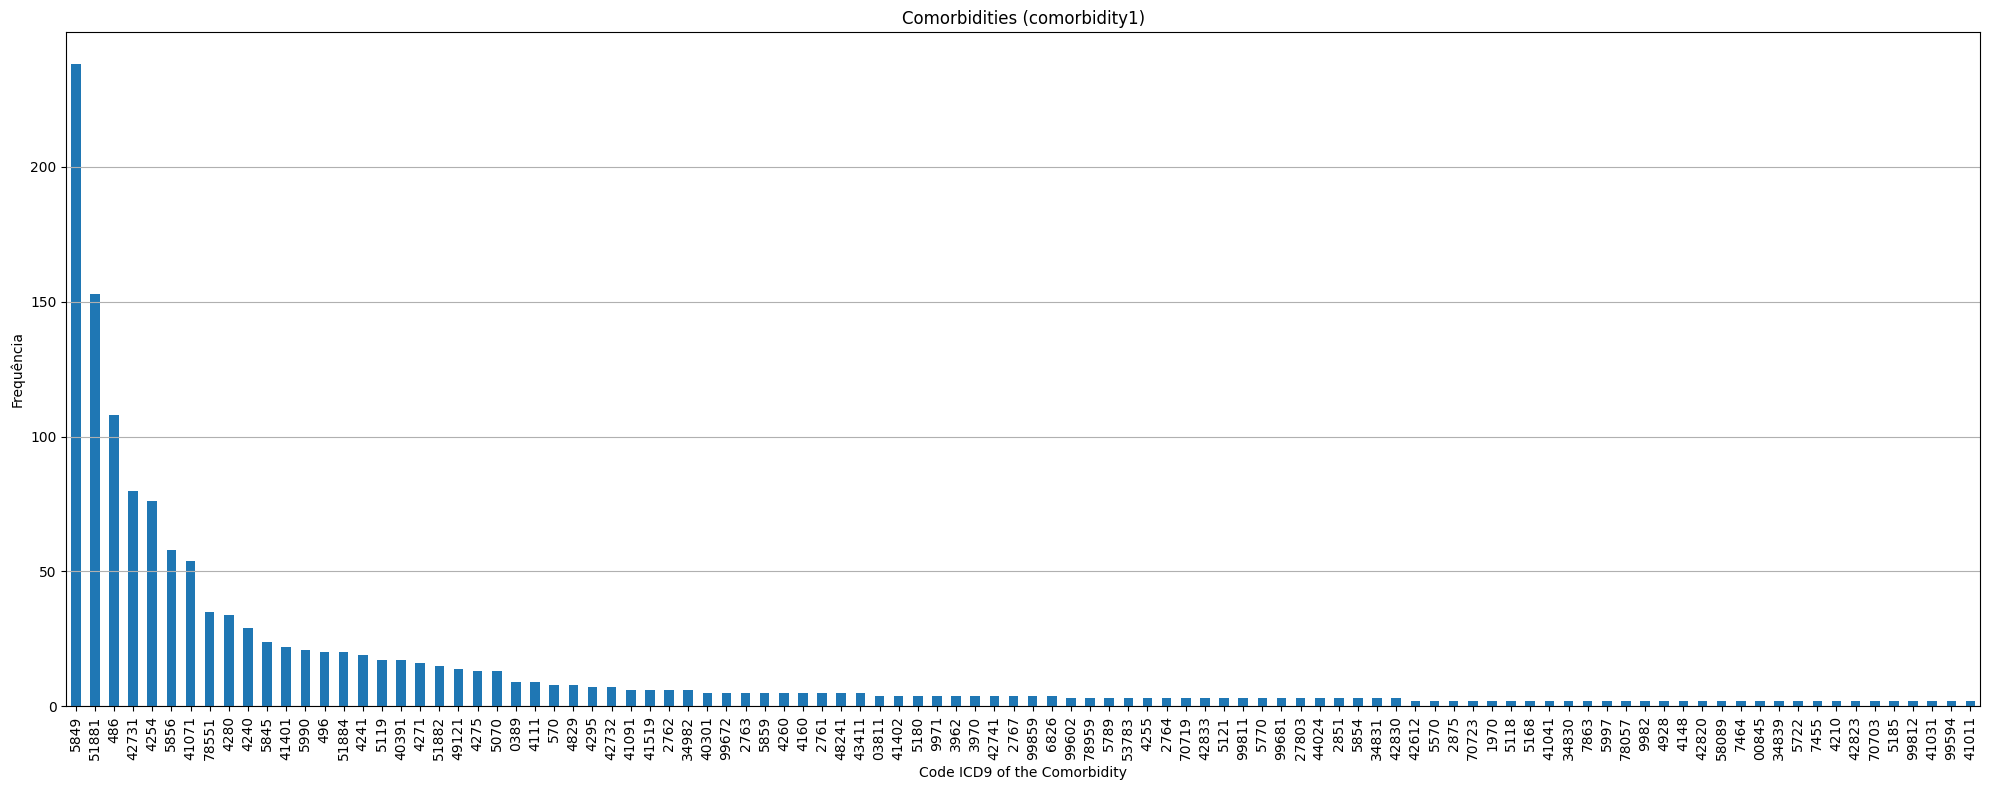

comorbidity1
5849     238
51881    153
486      108
42731     80
4254      76
Name: count, dtype: int64

In [247]:
counts1 = diagnoses_disease['comorbidity1'].value_counts()

c1 = sum(counts1[0:5])/sum(counts1[:]) 
print("Percentage of the frequency explained by the top 5 comorbities: " + str(c1*100) + " %")

plt.figure(figsize=(20,8))
counts_plot = counts1[0:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity1)')
plt.xlabel('Code ICD9 of the Comorbidity')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

counts1[0:5]

Percentage of the frequency explained by the top 5 comorbities2: 26.478494623655912 %


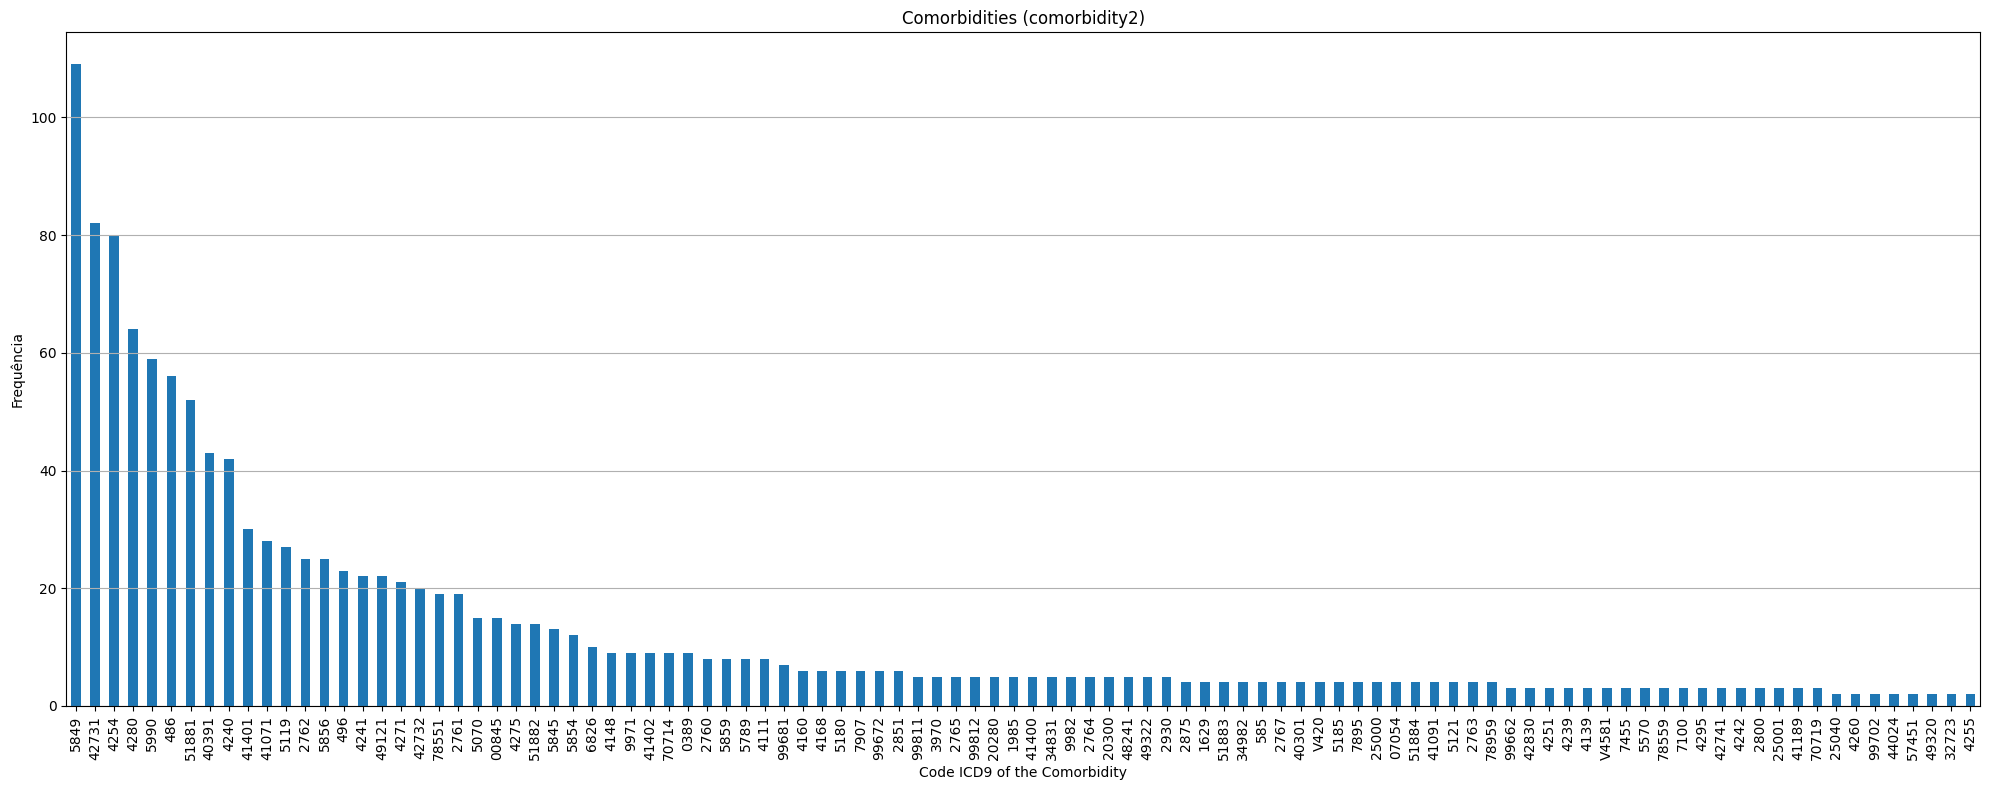

comorbidity2
5849     109
42731     82
4254      80
4280      64
5990      59
Name: count, dtype: int64

In [248]:
counts2 = diagnoses_disease['comorbidity2'].value_counts()

c2 = sum(counts2[0:5])/sum(counts2) 
print("Percentage of the frequency explained by the top 5 comorbities2: " + str(c2*100) + " %")

plt.figure(figsize=(20,8))
counts_plot = counts2[0:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity2)')
plt.xlabel('Code ICD9 of the Comorbidity')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

counts2[0:5]

In [249]:
print(f"Columns of Diagnosis: {diag.columns} \n")
print(f"Columns of Description of Diseases: {desc.columns} \n")
print(f"Columns of ICU Stays: {icustays.columns} \n")
print(f"Columns of Chart Events: {chartevents_filtered.columns} \n")
print(f"Columns of Patients: {patients.columns} \n")
print(f"Columns of Admissions: {admissions.columns} \n")

Columns of Diagnosis: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object') 

Columns of Description of Diseases: Index(['ROW_ID', 'ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE'], dtype='object') 

Columns of ICU Stays: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object') 

Columns of Chart Events: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME',
       'STORETIME', 'CGID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'WARNING',
       'ERROR', 'RESULTSTATUS', 'STOPPED'],
      dtype='object') 

Columns of Patients: Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object') 

Columns of Admissions: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHAR

### Data Preparation

In [250]:
top5 = diagnoses_disease['comorbidity1'].value_counts().index[:5]

# Create a new column for dummies but only for those top 5
diagnoses_disease['comorbidity1_top5'] = diagnoses_disease['comorbidity1'].where(
    diagnoses_disease['comorbidity1'].isin(top5), other='Other'
)

# Create dummies (excluding 'Other' if you want to drop it)
dummies = pd.get_dummies(diagnoses_disease['comorbidity1_top5'], prefix='comorbidity1')

# Optionally drop the 'Other' column (you can skip this line if you want to keep it)
dummies = dummies.drop(columns=['comorbidity1_Other'], errors='ignore')

# Concatenate back to the dataframe
diagnoses_disease = pd.concat([diagnoses_disease, dummies], axis=1)

In [251]:
top5 = diagnoses_disease['comorbidity2'].value_counts().index[:5]

# Create a new column for dummies but only for those top 5
diagnoses_disease['comorbidity2_top5'] = diagnoses_disease['comorbidity2'].where(
    diagnoses_disease['comorbidity2'].isin(top5), other='Other'
)

# Create dummies (excluding 'Other' if you want to drop it)
dummies = pd.get_dummies(diagnoses_disease['comorbidity2_top5'], prefix='comorbidity2')

# Optionally drop the 'Other' column (you can skip this line if you want to keep it)
dummies = dummies.drop(columns=['comorbidity2_Other'], errors='ignore')

# Concatenate back to the dataframe
diagnoses_disease = pd.concat([diagnoses_disease, dummies], axis=1)

In [252]:
len(diagnoses_disease)
diagnoses_disease.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,comorbidity1,comorbidity2,comorbidity1_top5,comorbidity1_4254,comorbidity1_42731,comorbidity1_486,comorbidity1_51881,comorbidity1_5849,comorbidity2_top5,comorbidity2_4254,comorbidity2_42731,comorbidity2_4280,comorbidity2_5849,comorbidity2_5990
0,2154,175,176764,1.0,42831,51881,5070,51881,False,False,False,True,False,Other,False,False,False,False,False
1,2163,176,135828,1.0,4280,42731,4251,42731,False,True,False,False,False,Other,False,False,False,False,False
2,2172,177,143120,1.0,4280,51881,5119,51881,False,False,False,True,False,Other,False,False,False,False,False
3,2460,199,185360,1.0,4280,4254,4240,4254,True,False,False,False,False,Other,False,False,False,False,False
4,3596,305,122211,1.0,42820,99859,5070,Other,False,False,False,False,False,Other,False,False,False,False,False


In [253]:
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
chartevents_filtered['CHARTTIME'] = pd.to_datetime(chartevents_filtered['CHARTTIME'])

# Merge on ICUSTAY_ID or HADM_ID depending on your data
merged = pd.merge(chartevents_filtered, icustays[['ICUSTAY_ID', 'INTIME']], on='ICUSTAY_ID', how='inner')

# Compute time difference
merged['DAYS_FROM_INTIME'] = (merged['CHARTTIME'] - merged['INTIME']).dt.total_seconds() / 86400

# Filter for events within the first 24 hours
chartevents_first_day = merged[merged['DAYS_FROM_INTIME'] < 1].copy()

In [254]:
print(len(chartevents_first_day))
chartevents_first_day.head()

274508


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,INTIME,DAYS_FROM_INTIME
0,27124,165,170252,247247.0,223761,2170-10-03 18:00:00,2170-10-03 18:43:00,16187.0,97.3,97.3,?F,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.029248
1,27125,165,170252,247247.0,225664,2170-10-03 18:00:00,2170-10-03 18:43:00,20277.0,174.0,174.0,NaN,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.029248
2,27126,165,170252,247247.0,220277,2170-10-03 18:35:00,2170-10-03 18:43:00,16187.0,99.0,99.0,%,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.053553
3,27127,165,170252,247247.0,220045,2170-10-03 18:36:00,2170-10-03 18:43:00,16187.0,73.0,73.0,bpm,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.054248
4,27128,165,170252,247247.0,220210,2170-10-03 18:36:00,2170-10-03 18:43:00,16187.0,19.0,19.0,insp/min,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.054248


In [ ]:
dataset = icustays[['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS']]

print(len(dataset))

dataset = dataset.merge(admissions[['HADM_ID', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']], on=['HADM_ID'], how='left')

print(len(dataset))

dataset = dataset.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], on='SUBJECT_ID', how='left')

print(len(dataset))

dataset = dataset.merge(diagnoses_disease[["HADM_ID", "comorbidity1_4254",	"comorbidity1_42731","comorbidity1_486","comorbidity1_51881","comorbidity1_5849","comorbidity2_4254","comorbidity2_4280",	"comorbidity2_42731",	"comorbidity2_5849",	"comorbidity2_5990"]], on="HADM_ID", how="left")
#dataset = dataset.merge(diagnoses_disease[["HADM_ID", "comorbidity1","comorbidity2"]], on="HADM_ID", how="left")

print(len(dataset))

dataset = dataset.merge(chartevents_first_day[['ICUSTAY_ID', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME']], on=['ICUSTAY_ID'], how="left")

print(len(dataset))


dataset.columns

1623
1623
1623
1623
275272


Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMITTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DOB', 'comorbidity1_4254',
       'comorbidity1_42731', 'comorbidity1_486', 'comorbidity1_51881',
       'comorbidity1_5849', 'comorbidity2_4254', 'comorbidity2_4280',
       'comorbidity2_42731', 'comorbidity2_5849', 'comorbidity2_5990',
       'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME'],
      dtype='object')

In [256]:
print(len(dataset))
print(dataset.nunique())
dataset.isna().sum()

275272
ICUSTAY_ID             1623
SUBJECT_ID             1264
HADM_ID                1484
LOS                    1595
ADMITTIME              1484
ADMISSION_TYPE            3
ADMISSION_LOCATION        6
INSURANCE                 5
RELIGION                 16
MARITAL_STATUS            7
ETHNICITY                25
GENDER                    2
DOB                    1249
comorbidity1_4254         2
comorbidity1_42731        2
comorbidity1_486          2
comorbidity1_51881        2
comorbidity1_5849         2
comorbidity2_4254         2
comorbidity2_4280         2
comorbidity2_42731        2
comorbidity2_5849         2
comorbidity2_5990         2
ITEMID                  646
VALUE                  4246
VALUENUM               3231
VALUEUOM                 74
DAYS_FROM_INTIME      30738
dtype: int64


ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURANCE                 0
RELIGION                329
MARITAL_STATUS         2683
ETHNICITY                 0
GENDER                    0
DOB                       0
comorbidity1_4254         0
comorbidity1_42731        0
comorbidity1_486          0
comorbidity1_51881        0
comorbidity1_5849         0
comorbidity2_4254         0
comorbidity2_4280         0
comorbidity2_42731        0
comorbidity2_5849         0
comorbidity2_5990         0
ITEMID                  764
VALUE                  1967
VALUENUM              12533
VALUEUOM              23907
DAYS_FROM_INTIME        764
dtype: int64

In [257]:
dataset = dataset.dropna(subset=["ITEMID"])
print(dataset.isna().sum())
dataset = dataset.dropna(subset=["VALUE"])
print(dataset.isna().sum())

ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURANCE                 0
RELIGION                324
MARITAL_STATUS         2667
ETHNICITY                 0
GENDER                    0
DOB                       0
comorbidity1_4254         0
comorbidity1_42731        0
comorbidity1_486          0
comorbidity1_51881        0
comorbidity1_5849         0
comorbidity2_4254         0
comorbidity2_4280         0
comorbidity2_42731        0
comorbidity2_5849         0
comorbidity2_5990         0
ITEMID                    0
VALUE                  1203
VALUENUM              11769
VALUEUOM              23143
DAYS_FROM_INTIME          0
dtype: int64
ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURAN

In [258]:
print(len(dataset))
print(dataset.nunique())

273305
ICUSTAY_ID              859
SUBJECT_ID              670
HADM_ID                 791
LOS                     847
ADMITTIME               791
ADMISSION_TYPE            3
ADMISSION_LOCATION        6
INSURANCE                 5
RELIGION                 16
MARITAL_STATUS            7
ETHNICITY                25
GENDER                    2
DOB                     669
comorbidity1_4254         2
comorbidity1_42731        2
comorbidity1_486          2
comorbidity1_51881        2
comorbidity1_5849         2
comorbidity2_4254         2
comorbidity2_4280         2
comorbidity2_42731        2
comorbidity2_5849         2
comorbidity2_5990         2
ITEMID                  642
VALUE                  4246
VALUENUM               3231
VALUEUOM                 74
DAYS_FROM_INTIME      30737
dtype: int64


Ethinicity

In [259]:
print(dataset.ETHNICITY.unique())

['WHITE' 'BLACK/AFRICAN AMERICAN' 'UNKNOWN/NOT SPECIFIED'
 'HISPANIC OR LATINO' 'ASIAN' 'OTHER' 'WHITE - RUSSIAN'
 'WHITE - BRAZILIAN' 'BLACK/HAITIAN' 'ASIAN - CHINESE'
 'WHITE - OTHER EUROPEAN' 'PORTUGUESE' 'UNABLE TO OBTAIN'
 'BLACK/CAPE VERDEAN' 'ASIAN - FILIPINO' 'ASIAN - CAMBODIAN'
 'AMERICAN INDIAN/ALASKA NATIVE' 'HISPANIC/LATINO - PUERTO RICAN'
 'PATIENT DECLINED TO ANSWER' 'ASIAN - ASIAN INDIAN' 'BLACK/AFRICAN'
 'HISPANIC/LATINO - DOMINICAN' 'WHITE - EASTERN EUROPEAN' 'MIDDLE EASTERN'
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)']


In [260]:

ethnicity_map = {
    'WHITE': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',

    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/AFRICAN': 'Black',
    'BLACK/HAITIAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',

    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - FILIPINO': 'Asian',
    'ASIAN - CAMBODIAN': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',

    'HISPANIC OR LATINO': 'Hispanic/Latino',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'Hispanic/Latino',

    'PORTUGUESE': 'Other',
    'MIDDLE EASTERN': 'Other',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Other',

    'OTHER': 'Other',
    'UNABLE TO OBTAIN': 'Other',
    'UNKNOWN/NOT SPECIFIED': 'Other',
    'PATIENT DECLINED TO ANSWER': 'Other',
}
dataset['ETHNICITY_GROUPED'] = dataset['ETHNICITY'].map(ethnicity_map).fillna('Other')


##### ANOVA

# Drop rows with missing LOS or ethnicity
anova_data = dataset.dropna(subset=['LOS', 'ETHNICITY_GROUPED'])

# Group by ethnicity
groups = [group['LOS'].values for name, group in anova_data.groupby('ETHNICITY_GROUPED')]

# ANOVA test
f_stat, p_value = f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.5f}")

dataset = dataset.drop(columns=["ETHNICITY"])
dataset.columns

F-statistic: 556.652
P-value: 0.00000


Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMITTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'GENDER', 'DOB', 'comorbidity1_4254',
       'comorbidity1_42731', 'comorbidity1_486', 'comorbidity1_51881',
       'comorbidity1_5849', 'comorbidity2_4254', 'comorbidity2_4280',
       'comorbidity2_42731', 'comorbidity2_5849', 'comorbidity2_5990',
       'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME',
       'ETHNICITY_GROUPED'],
      dtype='object')

Marital Status

In [261]:
print(dataset.MARITAL_STATUS.unique())

['MARRIED' 'WIDOWED' nan 'SINGLE' 'SEPARATED' 'DIVORCED' 'LIFE PARTNER'
 'UNKNOWN (DEFAULT)']


In [262]:
marital_map = {
    'MARRIED' : 'MARRIED',
    'LIFE PARTNER' : 'MARRIED',
    'WIDOWED' : 'WIDOWED',
    'DIVORCED' : 'DIVORCED',
    'SEPARATED' : 'DIVORCED',
    'UNKNOWN (DEFAULT)' : 'UNKNOWN (DEFAULT)',
    'SINGLE' : 'SINGLE'
}

dataset['MARITAL_STATUS'] = dataset['MARITAL_STATUS'].map(marital_map).fillna('UNKNOWN (DEFAULT)')
print(dataset.MARITAL_STATUS.unique())
dataset.MARITAL_STATUS.value_counts()

##### ANOVA

# Drop rows with missing LOS or ethnicity
anova_data = dataset.dropna(subset=['LOS', 'MARITAL_STATUS'])

# Group by ethnicity
groups = [group['LOS'].values for name, group in anova_data.groupby('MARITAL_STATUS')]

# ANOVA test
f_stat, p_value = f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.5f}")

['MARRIED' 'WIDOWED' 'UNKNOWN (DEFAULT)' 'SINGLE' 'DIVORCED']
F-statistic: 892.941
P-value: 0.00000


Religion

In [ ]:
print(dataset.RELIGION.value_counts())

RELIGION
CATHOLIC               117475
JEWISH                  51526
NOT SPECIFIED           43810
PROTESTANT QUAKER       31686
UNOBTAINABLE             6740
EPISCOPALIAN             5637
OTHER                    4915
GREEK ORTHODOX           3725
BUDDHIST                 3012
MUSLIM                   1359
CHRISTIAN SCIENTIST       963
BAPTIST                   873
ROMANIAN EAST. ORTH       549
HINDU                     273
JEHOVAH'S WITNESS         259
7TH DAY ADVENTIST         222
Name: count, dtype: int64


In [ ]:
dataset['RELIGION'] = dataset['RELIGION'].replace('UNOBTAINABLE', 'OTHER')
dataset['RELIGION'] = dataset['RELIGION'].replace('NOT SPECIFIED', 'OTHER')
dataset['RELIGION'] = dataset['RELIGION'].fillna('OTHER')


anova_data = dataset.dropna(subset=['LOS', 'RELIGION'])

# Group by ethnicity
groups = [group['LOS'].values for name, group in anova_data.groupby('RELIGION')]

# ANOVA test
f_stat, p_value = f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.5f}")

F-statistic: 870.009
P-value: 0.00000


In [266]:
# 1. Converte 'ADMITTIME' e 'DOB' para datetime (com erros forçados como NaT)
dataset['ADMITTIME'] = pd.to_datetime(dataset['ADMITTIME'], errors='coerce')
dataset['DOB'] = pd.to_datetime(dataset['DOB'], errors='coerce')

dataset['AGE'] = None

def safe_calculate_age(row):
    try:
        if pd.isna(row['ADMITTIME']) or pd.isna(row['DOB']):
            return None
        if row['DOB'].year > 2200:
            return 89
        age = (row['ADMITTIME'] - row['DOB']).days / 365.242
        return 89 if age > 89 else age
    except Exception as e:
        return None

dataset['AGE'] = dataset.apply(safe_calculate_age, axis=1)

dataset['AGE'] = dataset['AGE'].fillna(200).astype(int)

dataset = dataset[dataset['AGE'] != 200]  # DROP

# 5. (opcional) dropa as colunas DOB e ADMITTIME
dataset.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

# Verifica
print(dataset[['SUBJECT_ID', 'AGE']].head())

   SUBJECT_ID  AGE
0         305   74
1         305   74
2         305   74
3         305   74
4         305   74


In [268]:
print(len(dataset))
dataset.columns

242377


Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'GENDER', 'comorbidity1_4254', 'comorbidity1_42731', 'comorbidity1_486',
       'comorbidity1_51881', 'comorbidity1_5849', 'comorbidity2_4254',
       'comorbidity2_4280', 'comorbidity2_42731', 'comorbidity2_5849',
       'comorbidity2_5990', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM',
       'DAYS_FROM_INTIME', 'ETHNICITY_GROUPED', 'AGE'],
      dtype='object')

In [274]:
dtemp = dataset.copy()
print(dtemp.columns)

dtemp = pd.get_dummies(dtemp, columns=['RELIGION'])
dtemp = pd.get_dummies(dtemp, columns=['MARITAL_STATUS'])
dtemp = pd.get_dummies(dtemp, columns=['ETHNICITY_GROUPED'])
dtemp = pd.get_dummies(dtemp, columns=['ADMISSION_TYPE'])
dtemp = pd.get_dummies(dtemp, columns=['ADMISSION_LOCATION'])
dtemp = pd.get_dummies(dtemp, columns=['INSURANCE'])
dtemp = pd.get_dummies(dtemp, columns=['GENDER'], drop_first=True)

dtemp = dtemp.drop(columns=['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM',
       'DAYS_FROM_INTIME'])

corr = dtemp.corr()
corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'GENDER', 'comorbidity1_4254', 'comorbidity1_42731', 'comorbidity1_486',
       'comorbidity1_51881', 'comorbidity1_5849', 'comorbidity2_4254',
       'comorbidity2_4280', 'comorbidity2_42731', 'comorbidity2_5849',
       'comorbidity2_5990', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM',
       'DAYS_FROM_INTIME', 'ETHNICITY_GROUPED', 'AGE'],
      dtype='object')


,LOS,comorbidity1_4254,comorbidity1_42731,comorbidity1_486,comorbidity1_51881,comorbidity1_5849,comorbidity2_4254,comorbidity2_4280,comorbidity2_42731,comorbidity2_5849,comorbidity2_5990,AGE,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_MUSLIM,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,ETHNICITY_GROUPED_Asian,ETHNICITY_GROUPED_Black,ETHNICITY_GROUPED_Hispanic/Latino,ETHNICITY_GROUPED_Other,ETHNICITY_GROUPED_White,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,GENDER_M
LOS,1.000000,-0.063701,-0.041744,-0.069371,0.116552,-0.102456,-0.027294,-0.092197,-0.056260,0.046943,-0.064452,0.020569,0.053777,0.137557,0.009463,-0.036915,-0.038553,-0.029841,-0.021393,-0.023509,0.067032,0.028386,-0.052771,-0.053752,-0.015834,-0.033558,0.083510,-0.015873,-0.046891,-0.053566,0.060594,-0.058428,-0.028202,-0.020347,0.049157,-0.027794,-0.038671,0.149151,-0.079633,-0.065945,0.015979,0.176277,0.012786,-0.023036,0.016795,0.041577,-0.032272,0.010826,-0.034825,0.095125
comorbidity1_4254,-0.063701,1.000000,-0.014445,-0.050261,-0.072750,-0.097657,-0.045928,0.116325,0.006366,-0.036343,-0.013602,-0.097371,-0.010947,-0.020424,0.028434,-0.011499,-0.014856,-0.020943,-0.006114,-0.005955,-0.062490,-0.013672,0.046723,-0.002633,-0.007844,0.068831,-0.009402,0.023999,-0.020175,-0.053914,-0.026221,0.017984,-0.009046,0.010471,-0.008297,0.091673,-0.133578,0.113945,-0.004196,-0.086837,0.161877,-0.035771,-0.006630,-0.012615,0.145806,-0.007614,-0.000875,-0.042599,-0.011865,0.040374
comorbidity1_42731,-0.041744,-0.014445,1.000000,-0.021900,-0.031700,-0.042553,-0.020012,-0.016759,-0.011446,-0.023775,0.182817,0.029606,-0.004770,-0.008899,0.002168,-0.005011,-0.006473,0.079382,-0.002664,-0.002595,0.014805,-0.005957,-0.040381,0.010900,-0.003418,-0.022958,0.058603,-0.016748,-0.008791,-0.038858,-0.011426,-0.029681,-0.015525,-0.027747,0.050577,-0.025228,0.027951,-0.010919,0.002372,0.050467,-0.032010,-0.034702,-0.002889,-0.005497,-0.010681,0.020779,0.024497,-0.036851,-0.005170,0.064996
comorbidity1_486,-0.069371,-0.050261,-0.021900,1.000000,-0.110300,-0.148064,-0.069634,-0.034372,-0.039826,0.132769,-0.015034,0.089846,0.217801,-0.030966,-0.000573,0.046743,0.030460,-0.031753,-0.009270,-0.009029,0.057200,-0.020729,-0.034787,-0.047130,-0.011892,-0.020550,-0.053824,0.039197,-0.030589,0.049860,-0.039756,-0.004569,-0.019369,0.005032,0.020276,-0.087781,0.097258,-0.037994,-0.035163,0.051365,-0.101690,0.083182,-0.010053,-0.019126,-0.010891,0.020100,0.054039,-0.068191,-0.017990,-0.029837
comorbidity1_51881,0.116552,-0.072750,-0.031700,-0.110300,1.000000,-0.214315,-0.027177,-0.030286,0.007169,0.042424,0.003891,0.046237,-0.024023,-0.044822,-0.056201,0.033771,0.019546,-0.045961,-0.013417,-0.013069,0.134451,0.012011,-0.052519,0.023967,-0.017214,-0.032803,-0.036709,0.048666,0.019935,0.012664,-0.008406,0.051876,0.040747,-0.065973,-0.006530,-0.076473,0.050878,0.045445,0.010229,0.110390,-0.119114,-0.045107,-0.014551,0.039692,0.004794,-0.020380,0.028678,-0.027393,0.033377,-0.047759
comorbidity1_5849,-0.102456,-0.097657,-0.042553,-0.148064,-0.214315,1.000000,0.204585,0.004298,-0.001831,-0.160736,-0.009141,-0.127340,-0.032248,-0.060167,0.017103,-0.033876,-0.018591,0.031749,0.062606,0.060978,-0.046079,-0.040276,0.047234,-0.005938,-0.023107,-0.000459,0.047973,-0.041900,-0.016273,-0.012465,-0.058081,-0.007843,0.107575,0.122690,-0.10

In [290]:
corr[abs(corr.iloc[0]) > 0.08].iloc[:,0]

LOS                                             1.000000
comorbidity1_51881                              0.116552
comorbidity1_5849                              -0.102456
comorbidity2_4280                              -0.092197
RELIGION_BUDDHIST                               0.137557
MARITAL_STATUS_MARRIED                          0.083510
ADMISSION_TYPE_URGENT                           0.149151
ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM    0.176277
GENDER_M                                        0.095125
Name: LOS, dtype: float64

In [14]:
print(pd.unique(dataset.ITEMID.dropna().astype(int)))
dataset.ITEMID.nunique()

[   212    456    550    642    644    646    663    674    677    678
    680    704    707    723    742   1046   1087   1125   1337   1425
   1622   1623    159    161    211    581    618    807    593    599
    617    637    660    733    763    446    467    470    522    524
    525    527   1044   1045   1089    113    238    283    324    813
     27     31     32     54     72     80     82     83     84     85
     86     87     88    154    165    166    167    168    169    170
    171    172    184    198    210    344    357    363    374    375
    425    428    432    454    477    478    479    547    621     69
    762    916    917    919    920    924    925    926    927    930
    935    230    232    345    356    580    582    640    781    784
    787    788    791    811    814    821    827    828    829    833
    837    855    861   1127   1162   1523   1525   1529   1532   1534
   1535   1536   1542   1484     52    128     77    139   7914    187
    19

752

In [58]:
dataset = dataset.merge(items[["LABEL", "ITEMID"]], on="ITEMID", how="left")

In [ ]:
#dataset[['LABEL', 'ITEMID', 'VALUE', 'SUBJECT_ID']].to_csv('items_processed.csv', index=False)

In [59]:
dataset['LABEL'] = dataset['LABEL'].str.lower()
print(len(dataset[dataset['LABEL'] == "heart rate"]))
print(dataset[dataset['LABEL'] == "heart rate"]["ICUSTAY_ID"].nunique())
result = dataset[dataset['LABEL'] == "heart rate"].groupby('SUBJECT_ID')['ITEMID'].unique()
result

6764
70


SUBJECT_ID
176         [211.0]
177         [211.0]
199         [211.0]
205         [211.0]
323         [211.0]
            ...    
95325    [220045.0]
96094    [220045.0]
97649    [220045.0]
98182    [220045.0]
99067    [220045.0]
Name: ITEMID, Length: 65, dtype: object

In [63]:
label_counts = dataset.groupby('LABEL')['ICUSTAY_ID'].nunique().reset_index(name='count')
label_counts = label_counts.sort_values(by='count', ascending=False)
print(label_counts)
sum(label_counts["count"])

          LABEL  count
226  hemoglobin     89
89          bun     83
598         wbc     83
133  creatinine     83
269         inr     79
..          ...    ...
3       abi (r)      1
2       abi (l)      1
0         aado2      1
602      zzo2av      1
603     zzo2avi      1

[604 rows x 2 columns]


8315

Preprocessing Items table. Needed because a lot of the same items are duplicated with different ITEMIDs. Example: heart rate

In [17]:
print(items[items['ITEMID'] == 211].LABEL)
print(items[items['ITEMID'] == 220045].LABEL)

print("\n")

print(len(items))
items['LABEL'].nunique()

475    Heart Rate
Name: LABEL, dtype: object
11498    Heart Rate
Name: LABEL, dtype: object


12487


11846

In [ ]:
items['LABEL'] = items['LABEL'].str.lower()
items['LABEL'].nunique()
#items.to_csv('items_processed.csv', index=False)

In [ ]:
vitals_labs = ['heart rate', 'systolic bp', 'diastolic bp', 'respiratory rate', 'SpO2', 'BNP', 'Creatinine', 'Sodium']

### Training and Validation

### Analysis of Results and Interpretation